In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

from spillover_noise_q_env_config import (
    q_env_config as gate_q_env_config,
    circuit_context, phi, gamma
)
from quantumenvironment import QuantumEnvironmentV2
from context_aware_quantum_environment import ContextAwareQuantumEnvironmentV2
from hyperparameter_optimization import HyperparameterOptimizer
from gymnasium.wrappers import RescaleAction, ClipAction

from spillover_noise_quantum_environment import SpilloverNoiseQuantumEnvironment

from hpo_training_config import (
    HPOConfig,
    TotalUpdates,
    HardwareRuntime,
    TrainingDetails,
    TrainingConfig,
    TrainFunctionSettings
)

import logging
logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-06-14 17:29:06,212 - qm - INFO     - Starting session: 0365fc3b-764e-4dcc-803c-074a24da71c3

 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'unitary']
  Instructions with noise: ['custom_kron(rx,ident)_gate']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('custom_kron(rx,ident)_gate', (0, 1))] 

Circuit context
                 ┌─────────────────────────────┐     
        q_0 -> 0 ┤0                            ├──■──
                 │  custom_kron(rx,ident)_gate │┌─┴─┐
        q_1 -> 1 ┤1                            ├┤ X ├
                 └─────────────────────────────┘└───┘
  ancilla_0 -> 2 ────────────────────────────────────
                                                     
  ancilla_1 -> 3 ────────────────────────────────────
                                                     
  ancilla_2 -> 4 ────────────────────────────────────
                                                     
  ancilla_3 -> 5 ────────────────────────────────────
                    

In [2]:
gate_q_env_config.backend_config.instruction_durations_dict

In [3]:
q_env = SpilloverNoiseQuantumEnvironment(
    gate_q_env_config, circuit_context, (phi, gamma)
)
q_env = ClipAction(q_env)
q_env = RescaleAction(q_env, -1.0, 1.0)

q_env.unwrapped.backend

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>)

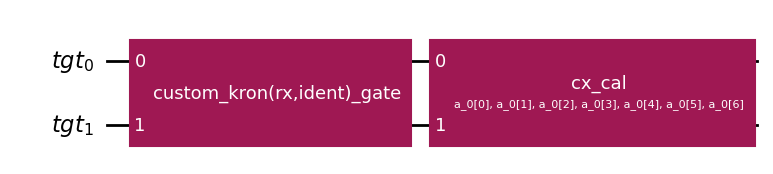

In [4]:
q_env.unwrapped.circuits[0].draw("mpl")

In [5]:
from helper_functions import load_from_yaml_file
from ppoV2 import CustomPPOV2

agent_config = load_from_yaml_file('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml')

ppo_agent = CustomPPOV2(agent_config, q_env)

In [6]:
total_updates = TotalUpdates(10)
# hardware_runtime = HardwareRuntime(300)
training_details = TrainingDetails(training_constraint=total_updates, target_fidelities=[0.999, 0.9999], lookback_window=10, anneal_learning_rate=True, std_actions_eps=1e-2)
training_config = TrainingConfig(training_mode="spillover_noise_use_case", training_details=training_details)

In [7]:
train_function_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=True,
    num_prints=1,
    hpo_mode=False,
    clear_history=True
)

In [8]:
q_env.unwrapped.phi_gamma_tuple

(0.7853981633974483, 0.01)

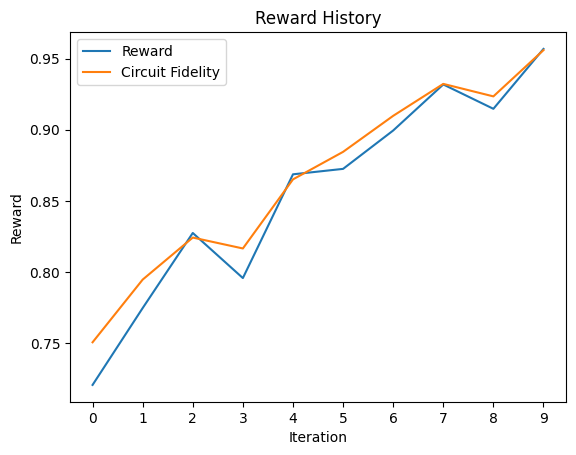

100%|██████████| 10/10 [01:53<00:00, 11.32s/it]

2024-06-14 17:31:00 INFO Target fidelity 0.999 not achieved within TotalUpdates(total_updates=10).
2024-06-14 17:31:00 INFO Target fidelity 0.9999 not achieved within TotalUpdates(total_updates=10).


{'training_mode': 'spillover_noise_use_case',
 'reward_method': 'state',
 'training_constraint': TotalUpdates(total_updates=10),
 'avg_reward': [0.7207060759961517,
  0.7747057959395127,
  0.8274404455462188,
  0.7957686293589237,
  0.8686519969593398,
  0.8724735661996931,
  0.8994332218590357,
  0.9317644217417027,
  0.9146685912624842,
  0.9567370063686669],
 'std_action': [array([0.49195585, 0.52107805, 0.48912522, 0.47094643, 0.47318578,
         0.5820591 , 0.5035012 ], dtype=float32),
  array([0.41822904, 0.49063194, 0.46166113, 0.46853942, 0.4221946 ,
         0.48639908, 0.48854223], dtype=float32),
  array([0.33036882, 0.4215623 , 0.39505604, 0.48902833, 0.35197335,
         0.38235316, 0.44642624], dtype=float32),
  array([0.33563465, 0.41953486, 0.41210335, 0.46499497, 0.33803236,
         0.35186997, 0.4279549 ], dtype=float32),
  array([0.24739073, 0.32352734, 0.3398488 , 0.39624074, 0.27488208,
         0.33623493, 0.36200896], dtype=float32),
  array([0.23833239, 0.2886

In [9]:
ppo_agent.train(
    training_config=training_config,
    train_function_settings=train_function_settings
)